In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 

from tqdm.notebook import tqdm
import pandas as pd

# from Boltzmann_Function_gen_2 import *
# from sklearn.cluster import KMeans
# from scipy.cluster.vq import kmeans2, whiten, kmeans
# from time import time
# from scipy.special import expit
import onehot as oh
import book_cleaner as books
import re
from importlib import reload
import os
import inspect
#!sh "/Applications/Python 3.12.6/Install Certificates.command"
# Tuype above in terminal to fix ssl error
reload(books)

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/vinayramanathan/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vinayramanathan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vinayramanathan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vinayramanathan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vinayramanathan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/vinayramanathan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package gutenberg t

<module 'book_cleaner' from '/Users/vinayramanathan/RBM_research/Energy-based-LLM/book_cleaner.py'>

In [2]:
############# K-means clustering Functions ############
## Helpers


def Manhattan_dist(Centers, P2):
    
    Difference = Centers-P2
    
    Dist = np.abs((Difference))
    return Dist




def kmeans_details_verbose_manhattan(Points, Centers, metric = "Euclidean"):
    Distance_min =[]
    Cluster_id=[]
    Avg_dist = []

    Num_clusters = len(Centers)

    for p in Points:
        Distances = Manhattan_dist(Centers, p)

        minimal_distance = float(np.min(Distances))

        Avg_distance = (np.mean(Distances))

        Cluster_assignment = int(np.argmin(Distances))

        Distance_min.append(minimal_distance)
        Cluster_id.append(Cluster_assignment)
        Avg_dist.append(Avg_distance)

    return np.array(Avg_dist), np.array(Cluster_id), np.array(Distance_min)




def Euc_dist_point(P1, P2):
    
    Difference = P1-P2
    
    Dist = np.sqrt(np.sum(Difference**2))
    return Dist

def Euc_dist(Centers, P2):
    
    Difference = Centers-P2
    
    Dist = np.sqrt(np.sum(Difference**2, axis = 1))
    return Dist




def kmeans_details_verbose(Points, Centers, metric = "Euclidean"):
    Distance_min =[]
    Cluster_id=[]
    Avg_dist = []

    Num_clusters = len(Centers)

    for p in Points:
        if metric == "Euclidean":
            ## default
            Distances = Euc_dist(Centers, p)
        else:
            Distances = Manhattan_dist(Centers, p)

        minimal_distance = float(np.min(Distances))

        Avg_distance = (np.mean(np.sort(Distances)))

        Cluster_assignment = int(np.argmin(Distances))

        Distance_min.append(minimal_distance)
        Cluster_id.append(Cluster_assignment)
        Avg_dist.append(Avg_distance)

    return np.array(Avg_dist), np.array(Cluster_id), np.array(Distance_min)


def kmeans_details_verbose_1(Points, Centers):
    Distance_array =[]
    Cluster_id=[]
    Avg_dist = []

    Num_clusters = len(Centers)

    for p in Points:
        Distances = Euc_dist(Centers, p)

        Distance_array.append(Distances)
        Cluster_assignment = int(np.argmin(Distances))
        Cluster_id.append(Cluster_assignment)
        

    return  np.array(Cluster_id), np.array(Distance_array)



def Coefficient_to_vector(Coefficient_list, Vector_list, plot=False):
    Z = np.zeros(len(Coefficient_list))
    for i,c in enumerate(Coefficient_list):
        Z+= c * Vector_list[i]

    if plot == False:
        return Z
    else:
        return Vec_to_img(Z)
    


############# End K-means clustering Functions ############




###### Helpers #####

def make_unfurled_state(State, Ordered_alphabet_list):
    """----- Compact State 
    er ----
    --- takes compact state in alphabet notation

    --- takes alphabet list in order (alphabet list size = n)
    --- takes subsequent alphabet into one hot encoded basis
     """

    num_features = len(State)
    num_alphabet = len(Ordered_alphabet_list)

    length_unfurled = num_features * num_alphabet

    unfurled_state = []

    for value in State:

        alphabet_unfurled = np.zeros(num_alphabet)

        arg_where_one = np.argwhere(Ordered_alphabet_list ==value)
        alphabet_unfurled[arg_where_one] =1
        unfurled_state.append(alphabet_unfurled)

    unfurled_state = np.ravel(np.array(unfurled_state))

    # check if unfurled length matches expected length:
    if len(unfurled_state) != length_unfurled:
        print("Unfurled state length does not match expected length")
        print("Expected:", length_unfurled)
        print("Actual:", len(unfurled_state))
        return

    return unfurled_state


def make_compact_state(unfurled_state, ordered_alphabet_list):

    """----- Unfurled State Compactor ----
    --- takes one hot encoded unfurled state
    --- takes alphabet list in order (alphabet list size = n)
    --- takes subsequent 'n' elements and converts it into corresponding alphabet    
     """
    
    num_alphabet = len(ordered_alphabet_list)
    num_unfurled_features = len(unfurled_state)

    State = []

    for i in range(0, num_unfurled_features, num_alphabet):

        start = i
        stop = i +num_alphabet

        read_state = unfurled_state[start:stop]

        if np.sum(read_state)!=1:
            print("State cannot have two alphabets at the same location. Check:", start, stop)
            return 

        arg_true = np.ravel(np.argwhere(read_state ==1))

        State.append(ordered_alphabet_list[arg_true])

    State = np.array(State)

    return State

def Checker(seq, Train_data_unfurled):
    Checker = np.sum(seq == Train_data_unfurled, axis=1)
    max_val = np.max(Checker)
    arg_max = np.argmax(Checker)

    if max_val == np.sum(Train_data_unfurled[0] == Train_data_unfurled[0]):
        Status = True
    else:
        Status = False
    return Status, max_val, arg_max




def Von_Neumann_Entropy_per_residue(Data_unfurled, Alphabet_size = 21):

    """Calculates Von Neumann Entropy for each site for the unfurled dataset:

    Inputs:
        - Unfurled Data Set (Each site is represented as one hot encoded vector of length =Alphabet size)

        - Alphabet size: Total number of Alphabets

    Output:
        -Von Neumann entropy (Base 2) for each site
        - Effective dimension = Base ^ (Von Neumann entropy)
        """

    ### First thing, check if alphabet size is correct:
    Length_one_hot_encoded = np.shape(Data_unfurled)[1],
    if np.mod(Length_one_hot_encoded, Alphabet_size)>0:
        print("Data Size and Alphabet size mismatch")
        return None
     
    VN_site = []

    for i in range(0, np.shape(Data_unfurled)[1], Alphabet_size):
        start = i
        end = i+ Alphabet_size

        Data = Data_unfurled[:, start:end]
        _,si,_ = np.linalg.svd(Data)

        Eigvals = si**2/np.sum(si**2)
        Eigvals_usable = Eigvals[np.ravel(np.argwhere(Eigvals>0.0))]

        VN_entropy_site_i = np.sum(-1*np.log2(Eigvals_usable) * Eigvals_usable)
    
        VN_site.append(VN_entropy_site_i)

    return np.array(VN_site)

    


def Softmax_probability_stable(Energy_list, sign = 1, temperature = 1):

    """----- stable softmax function that doesn't overflow ----
    --- if sign = 1 --> softmax of Energy_list (default)
    --- if sign = -1 --> softmin of Energy_list

    --- temperature scales energy by division (default temperature = 1)
    
     """
    Energy_array = np.array(Energy_list) * sign

    max_value = np.max(Energy_array)

    Energy_array_scaled = (Energy_array -max_value)/temperature

    likelihood_energy = np.exp(Energy_array_scaled)

    normalization = np.sum(likelihood_energy)

    Softmax = likelihood_energy/normalization

    return Softmax





def make_corrupted_data(Train_data, Ordered_alphabet_list, corruption_rate = 0.1):
    """----- Corruption of the data ----
    --- takes in the training data (compact) and corrupts it by a given rate
    --- returns the corrupted data
     """

    num_features = len(Train_data)
    num_alphabet = len(Ordered_alphabet_list)

    length_unfurled = num_features * num_alphabet

    corrupted_data = Train_data.copy()

    for i in range(num_features):
        if np.random.rand() < corruption_rate:
            corrupted_data[i] = np.random.choice(Ordered_alphabet_list, 1)[0]

    return corrupted_data



def Checker(seq, Train_data_unfurled):
    """Checks to see which sequence form the training data is closest to the given sequence (seq)
    
    - Input:
    seq= sequence in question
    Train_data_unfurled = Training dataset in the same basis
    
    -Output:
    - Status= True/False : Is the sequence in the training set
    - Max_val = maximul similarity value
    - arg_max = argument for the closest match in training data
    
    """

    Checker = np.sum(seq == Train_data_unfurled, axis=1)
    max_val = np.max(Checker)
    arg_max = np.argmax(Checker)

    if max_val == np.sum(Train_data_unfurled[0] == Train_data_unfurled[0]):
        Status = True
    else:
        Status = False
    return Status, max_val, arg_max




    


In [3]:
##### Boltzmann Machine ######

class Multimodal_Boltzmann_Machine:

    def __init__(self, num_unfurled_features, alphabet_list, learning_rate = 0.01, temperature = 1):
        """
        Initialize a multimodal Boltzmann Machine
        
        Parameters:
        -----------
        num_unfurled_features : int
            -- Number of features (sites/position) in the actual data
        num_states_per_unit : int
        alphabet_list: array
            -- possible states for each position
        learning_rate : float
            -- Learning rate for gradient updates
        """




        self.num_unfurled_features= num_unfurled_features

        self.alphabet_lists = alphabet_list
        
        self.learning_rate = learning_rate

        ##############
        self.num_alphabet = len(alphabet_list)

        self.num_features = num_unfurled_features// self.num_alphabet

        self.temperature= temperature

        ### check for error mismatch:
        if self.num_alphabet* self.num_features != num_unfurled_features:
            print("Check dimensions of alphabet list and unfurled state. Dimensional mis-match")
    

        ###############

        ##### initializing weights and bias 

        fundamental_connectivity = np.ones((num_unfurled_features, num_unfurled_features))


        for i in range(0, num_unfurled_features, len(alphabet_list)):
            start = i 
            end = i + len(alphabet_list)
            fundamental_connectivity[start:end, start:end]=0

        self.fundamental_connectivity = fundamental_connectivity



        Weight_random =np.random.normal(loc = 0, scale = learning_rate/10, size =(num_unfurled_features, num_unfurled_features))
        Weight_random *= fundamental_connectivity

        self.weights = Weight_random


        self.bias = np.random.normal(loc = 0, scale = learning_rate/10, size =num_unfurled_features)
        
        ### For tracking
        # col 1 is w_error, col2 is b_error, col 3 is recons_error at each iteration
        # col 4 is an array of the energies of the data calc at that iteration
        # len(tracker) gives number of iterations 
        # tracker[0] gives [w_error, b_error, recons_error, and energyArray] at iteration 0
        ### For tracking energy of training data over each iteration
        self.tracker = []
        self.energyTrainingData = []
        
        self.Adaptive = False # Initialize to false to avoid has no attribute 'Adaptive' error
    

  
    def tracker(self):
        return self.tracker
    

    def tracker(self, tracker2):
        self.tracker = tracker2
        

    def energyTrainingData(self):
        return self.tracker
    

    def energyTrainingData(self, energyTrainData):
        self.tracker = energyTrainData
        
    

    def set_weight(self, weight_matrix):
        fundamental_connection = self.fundamental_connectivity
        ###check shape before setting:
        D1, D2 = np.shape(weight_matrix)


        if D1!=self.num_unfurled_features or D2!=self.num_unfurled_features:
            print("Dimensional Mismatch between Boltzmann Machine and this weight matrix")
        else:
            self.weights = weight_matrix*fundamental_connection


    def set_bias(self, bias_vector):

        ###check shape before setting:
        D1 = len(bias_vector)
        if D1!=self.num_unfurled_features:
            print("Mismatch in the Dimension of Boltzmann Machine and this Bias vector")
        else:
            self.bias = bias_vector

    def get_weight_bias(self):

        W = self.weights
        B = self.bias

        return W, B

    def Energy_state(self, State_unfurled):

        Weight = self.weights
        Bias = self.bias
        
        ### I have absorbed the factor of two inside the weight
        Energy = - (State_unfurled.T @Weight@ State_unfurled) - (Bias @ State_unfurled)

        return Energy
    

    def Energy_array(self, Unfurled_State_array):
        Weights = self.weights
        Bias = self.bias

        #Energy_all = - (Full_partition@Weights@Full_partition.T) - (Full_partition@Bias.T)
        #Energy_all = -((Unfurled_State_array@Weights) + Bias) @ Unfurled_State_array.T
        #Energy_array = np.diag(Energy_all)

        Energy_all = np.sum(-((Unfurled_State_array@Weights) + Bias) * Unfurled_State_array, axis =1)


        return Energy_all


    

    
    def Softmax_probability_stable(self, Energy_list, sign = 1 , temperature = None):

        """----- stable softmax function that doesn't overflow ----
        --- if sign = 1 --> softmax of Energy_list (default)
        --- if sign = -1 --> softmin of Energy_list

        --- temperature scales energy by division (default temperature = 1)
        
        """

        ### if no temperature is given, use default temperature (which is set to 1).
        if None in np.array(temperature):
            temperature = self.temperature

        Energy_array = np.array(Energy_list) * sign

        max_value = np.max(Energy_array)

        Energy_array_scaled = (Energy_array - max_value)/temperature

        likelihood_energy = np.exp(Energy_array_scaled)

        normalization = np.sum(likelihood_energy)

        Softmax = likelihood_energy/normalization

        return Softmax



    def Activation_probability(self, State_unfurled, temperature=None):
            
            """Gives the activation probability for all degrees of freedom in the state"""
        
            Length = self.num_unfurled_features

            if None in np.array(temperature):
                temperature = self.temperature

            fundamental_connection = self.fundamental_connectivity

            num_alphabets = self.num_alphabet

            ### construct single change full partition space for this configuration:
            Full_partition = fundamental_connection * State_unfurled
            ### the diagonal of full partition must be 1 since we are sweeping through feature and alphabet.
            Full_partition+= np.eye(Length) 
        

            Weights = self.weights
            Bias = self.bias

            Probability_array = np.zeros(Length)

            for i in range(0,Length, num_alphabets):
                ### we will only take into account the piece of energy that is different 
                ### when we switch alphabet within a site.

                start = i
                end = i +num_alphabets

                ### the following vector contains the site in question as well as all the other sites
                ### Fundamental connectivity makes sure that we can slice the weight matrix as follows without running
                ### into issues of self connectivity.

                vec_i = Full_partition[start]  

                ###  Weights_i_all = effect of site in question on all other sites
                ### Weights_all_i = effect of all other sites on site in question
                Weights_i_all = Weights[:,start:end]

                Weights_all_i = Weights[start:end]

                E_i_all = vec_i @ Weights_i_all
                E_all_i = (Weights_all_i @ vec_i.T)

                E_site = -1*(E_i_all+E_all_i + Bias[start:end])

                Prob_site = self.Softmax_probability_stable(E_site, sign=-1, temperature=temperature)
                Probability_array[start:end]= Prob_site

            return Probability_array
    

    
    def Activation_probability_given_index(self, State_unfurled, indices_to_change, temperature = None):
            """Gives the activation probability for
              selected degrees of freedom (selected sites through given index) in the state"""
        
            Length = self.num_unfurled_features

            if None in np.array(temperature):
                temperature = self.temperature

            fundamental_connection = self.fundamental_connectivity

            num_alphabets = self.num_alphabet

            ### construct single change full partition space for this configuration:
            Full_partition = fundamental_connection * State_unfurled
            ### the diagonal of full partition must be 1 since we are sweeping through feature and alphabet.
            Full_partition+= np.eye(Length) 
        

            Weights = self.weights
            Bias = self.bias

            Probability_array = np.zeros(Length)

            for i in indices_to_change:
                ### we will only take into account the piece of energy that is different 
                ### when we switch alphabet within a site.

                start = i*num_alphabets
                end = start +num_alphabets


                ### the following vector contains the site in question as well as all the other sites
                ### Fundamental connectivity makes sure that we can slice the weight matrix as follows without running
                ### into issues of self connectivity.

                vec_i = Full_partition[start]  


                ###  Weights_i_all = effect of site in question on all other sites
                ### Weights_all_i = effect of all other sites on site in question
                Weights_i_all = Weights[:,start:end]

                Weights_all_i = Weights[start:end]

                E_i_all = vec_i @ Weights_i_all
                E_all_i = (Weights_all_i @ vec_i.T)

                E_site = -1*(E_i_all+E_all_i + Bias[start:end])

                Prob_site = self.Softmax_probability_stable(E_site, sign=-1,temperature=temperature)
                Probability_array[start:end]= Prob_site

            return Probability_array
        

    def Forward_Gibbs_pass_partitioned(self,State_unfurled, partition = 0.5 , temperature=None):

        #### rather than changing all sites, we will only change a fraction of the sites

        Length = self.num_features
        num_alphabet = self.num_alphabet


        if None in np.array(temperature):
            temperature=self.temperature


        Num_sites_to_change = int(Length*partition)
        ### get the indices of the sites to change
        indices_to_change = np.sort(np.random.choice(range(0, Length), Num_sites_to_change, replace=False))
        #indices_to_keep = np.setdiff1d(range(0, Length), indices_to_change)

        ### get the activation probability for the indices selected above for the state
        Activation_prob = self.Activation_probability_given_index(State_unfurled, indices_to_change, temperature)
        
        ### Initialize the Next State as as copy of the current state
        ### we will keep the indices that are not changing (by not operating on them)
        Next_state = State_unfurled.copy()
        #Next_state[indices_to_keep] = State_unfurled[indices_to_keep]

        for index in indices_to_change:

            start = index*num_alphabet
            stop = start + num_alphabet

            Prob_i = Activation_prob[start:stop]

            Picked_state = np.random.choice(range(0,num_alphabet), p=Prob_i)
            ## blank out the previous state at this site
            Next_state[start:stop] = 0
            
            ## replace it with the new state
            Next_state [start+Picked_state]=1

        return Next_state
    
    def gibbs_sampling_partitioned_states(self, state, k, partition=.5, temperature=None):
        if temperature==None:
            temperature = self.temperature
        states = []
        for i in range(0, k):
            state = self.Forward_Gibbs_pass_partitioned(state, partition, temperature=temperature)
            states.append(state)
        return states
    

    def Forward_Gibbs_pass(self,State_unfurled, temperature=None):
        Length = self.num_unfurled_features
        num_alphabet = self.num_alphabet

        if temperature==None:
            temperature=self.temperature
        
        ### get the activation probability for the state
        Activation_prob = self.Activation_probability(State_unfurled, temperature=temperature)

        ### Based on this probabilty, update the next 
        Next_state = np.zeros_like(State_unfurled)

        for i in range(0, Length, num_alphabet):
            start = i
            stop = i + num_alphabet
            Prob_i = Activation_prob[start:stop]
            Picked_state = np.random.choice(range(0,num_alphabet), p=Prob_i)
            #print(Picked_state)

            Next_state [i+Picked_state]=1

        return Next_state
    
    

    def gibbs_sampling(self, state, k, temperature=None):

        if temperature==None:
            temperature= self.temperature

        for i in range(0, k):
            state = self.Forward_Gibbs_pass(state, temperature=temperature)
        return state


    def gibbs_sampling_partitioned(self, state, k, partition = 0.5, temperature=None):
        if temperature==None:
            temperature = self.temperature

        for i in range(0, k):
            state = self.Forward_Gibbs_pass_partitioned(state, partition, temperature=temperature)
        return state
    


    def Random_state_unfurled(self):
        num_features = self.num_features
        num_alphabet = self.num_alphabet
        Ordered_alphabet_list = arr = np.array(self.alphabet_lists, dtype=str) # EDITED orig: self.alphabet_lists

        State = np.random.choice(Ordered_alphabet_list,num_features)
        length_unfurled = num_features * num_alphabet

        unfurled_state = []

        for value in State:

            alphabet_unfurled = np.zeros(num_alphabet)

            arg_where_one = np.argwhere(Ordered_alphabet_list ==value)
            
            alphabet_unfurled[arg_where_one] =1
            unfurled_state.append(alphabet_unfurled)

        unfurled_state = np.ravel(np.array(unfurled_state))

        return unfurled_state
    

    def Parallel_tempering(self, State=None, num_steps = 5, num_chains = 5, partition = 0.5,temperature_max = 5,temperature_min = 0.1):

        """Parallel tempering for the Boltzmann machine"""
        # Initialize state as random state if not provided
        if State is None:
            State = self.Random_state_unfurled()

        # Initialize chains
        chains = [State.copy() for _ in range(num_chains)]
        # Initialize energies
        energies = np.zeros((num_chains, len(State)))
        # Initialize temperatures (we need as many temperatures as chains)
        ## we use inverse-linear steps in temperature (this gives a much better distribution than linear steps)
        beta_list = np.linspace(1/temperature_min, 1/temperature_max, num_chains)
        temperature_list = 1/beta_list

        
        # Run parallel tempering
        for step in range(num_steps):
            for i in range(num_chains):
                # Perform Gibbs sampling
                chains[i] = self.Forward_Gibbs_pass_partitioned(chains[i], partition=partition, temperature=temperature_list[i])
            
            energies = self.Energy_array(chains)

            # Swap states between chains with different temperatures
            for i in range(num_chains - 1):
                ## choose different chain to exchange with
                #Choice_j = [n for n in range(0, num_chains - 1) if n!=i]
                #j = int(np.random.choice(Choice_j, 1))


        
                j = i+1 

                # Calculate swap probability
                # Avoid the overflow issue by hardcoding the power in swap exponential (exp of difference between things converges better)
                Power = (energies[i] - energies[j]) / ((1/temperature_list[i]) - (1/temperature_list[j]))
                if Power > 0:
                    swap_factor = 1
                else:
                    swap_factor = np.exp(Power)

                if np.random.rand() < swap_factor:
                    chains[i], chains[j] = chains[j], chains[i]
        
        return np.array(chains)

    
    def Parallel_tempering_full(self, State=None, num_steps = 5, num_chains = 5,temperature_max = 5,temperature_min = 0.1):

        """Parallel tempering for the Boltzmann machine"""
        # Initialize state as random state if not provided
        if State is None:
            State = self.Random_state_unfurled()

        # Initialize chains
        chains = [State.copy() for _ in range(num_chains)]
        # Initialize energies
        energies = np.zeros((num_chains, len(State)))
        # Initialize temperatures (we need as many temperatures as chains)
        temperature_list = np.linspace(temperature_min, temperature_max, num_chains)

        
        # Run parallel tempering
        for step in range(num_steps):
            for i in range(num_chains):
                # Perform Gibbs sampling
                chains[i] = self.Forward_Gibbs_pass(chains[i], temperature=temperature_list[i])
            
            energies = self.Energy_array(chains)


            # Swap states between chains with different temperatures
            for i in range(num_chains - 1):
                # Calculate swap probability
                # Avoid the overflow issue by hardcoding the power in swap exponential
                Power = (energies[i] - energies[i + 1]) / (temperature_list[i] - temperature_list[i + 1])
                if Power > 0:
                    swap_factor = 1
                else:
                    swap_factor = np.exp(Power)

                if np.random.rand() < swap_factor:
                    chains[i], chains[i + 1] = chains[i + 1], chains[i]
        
        return np.array(chains)


    def contrastive_divergence_adaptive_old(self, data_batch, k=1):
        """Contrastive Divergence with adaptive learning rates"""
        batch_size = len(data_batch)
        
        # Initialize parameter-specific adaptive learning rates if not exist
        if not hasattr(self, 'weight_lr_cache'):
            self.weight_lr_cache = self.fundamental_connectivity* self.learning_rate 

            self.bias_lr_cache = np.ones_like(self.bias) * self.learning_rate

            self.squared_grad_weights = np.zeros_like(self.weights)
            self.squared_grad_bias = np.zeros_like(self.bias)
            self.decay_rate = 0.9  # RMSProp decay rate
            self.epsilon = 1e-6    # Small constant for numerical stability
        
        # Compute gradients (same as regular CD-k)
        # Positive phase
        pos_associations = np.zeros_like(self.weights)
        for v_pos in data_batch:
            pos_associations += np.outer(v_pos, v_pos)
        pos_associations /= batch_size
        
        # Negative phase
        neg_associations = np.zeros_like(self.weights)
        neg_states = np.zeros_like(data_batch)
        
        for i, v_pos in enumerate(data_batch):
            v_neg = self.gibbs_sampling(v_pos, k)
            neg_states[i] = v_neg
            neg_associations += np.outer(v_neg, v_neg)
        
        neg_associations /= batch_size
        
        # Calculate gradients
        weight_gradients = pos_associations - neg_associations
        bias_gradients = np.mean(data_batch - neg_states, axis=0)
        
        # Apply connectivity constraints
        weight_gradients *= self.fundamental_connectivity
        
        # RMSProp-like update for adaptive learning rates
        self.squared_grad_weights = self.decay_rate * self.squared_grad_weights + (1 - self.decay_rate) * (weight_gradients ** 2)
        self.squared_grad_bias = self.decay_rate * self.squared_grad_bias + (1 - self.decay_rate) * (bias_gradients ** 2)
        
        # Compute adaptive learning rates
        adaptive_lr_weights = self.learning_rate / (np.sqrt(self.squared_grad_weights) + self.epsilon)
        adaptive_lr_bias = self.learning_rate / (np.sqrt(self.squared_grad_bias) + self.epsilon)


        
        # Apply updates with adaptive learning rates
        self.weights += adaptive_lr_weights * weight_gradients
        self.bias += adaptive_lr_bias * bias_gradients
        
        # Ensure symmetry
        self.weights = (self.weights + self.weights.T) / 2.0
        
        # Calculate reconstruction error
        reconstruction_error = np.mean(np.sum((data_batch - neg_states) ** 2, axis=1))
        
        return reconstruction_error



    def Stochastic_Contrastive_Divergence(self, Data_full, batch_fraction = 0.6, num_steps = 20, num_chains = 10, partition = 0.7, temperature_max = 5, temperature_min = 0.1, Adaptive = True):
        
        ### If Adaptive==False, then no RMS Prop. Raw learning rate is used
        if Adaptive:
            self.Adaptive = Adaptive
        else:
            ### clear out the stored squared gradients
            self.squared_grad_weights = np.zeros_like(self.weights)
            self.squared_grad_bias = np.zeros_like(self.bias)


        
        # Initialize parameter-specific adaptive learning rates if not exist
        if not hasattr(self, 'weight_lr_cache'):
            self.weight_lr_cache = np.ones_like(self.weights) * self.learning_rate
            
            self.bias_lr_cache = np.ones_like(self.bias) * self.learning_rate
            self.squared_grad_weights = np.zeros_like(self.weights)
            self.squared_grad_bias = np.zeros_like(self.bias)
            self.decay_rate = 0.9  # RMSProp decay rate
            self.epsilon = 1e-6    # Small constant for numerical stability


    


        ### Reinforced Hebbian Cycle begins 


        Energy_data = self.Energy_array(Data_full)
        Mean_energy = np.mean(Energy_data)
        Dev_energy = np.std(Energy_data)
        ### Scale energy by mean
        Scaled_energy = (Energy_data-Mean_energy)/ (Dev_energy + self.epsilon)

        ### emphasize examples at too high energy more
        ### deemphasize examples at too low energy
        P_learn = Softmax_probability_stable(Scaled_energy, sign = 1)
        P_forget =Softmax_probability_stable(Scaled_energy, sign = -1)

        ## Total probability
        P_eg = (1+ P_learn - P_forget)/ len(Data_full)


        ### converting P_eg to column vector using np.newaxis to broadcast for multiplication
        ### alternatively I can also reshape this using P_eg.reshape(-1,1) and multiply.

        Scaled_examples = Data_full * P_eg[:, np.newaxis]


        dw_hebb = Scaled_examples.T @ Data_full
        db_hebb = np.sum(Scaled_examples, axis = 0)


        #####End Hebbian Phase

        ### Anti Hebbian Phase  Begins:
        ### find good starting set- take data states and boil them to different temperatures:
        ### I will parallel temper these states again!

        ### Running Parallel_tempering without specifying a starting states starts it from a random state

        Kept_states = []

        dw_anti_hebb =0
        db_anti_hebb =0

        Min_energy_chain_elem=[]


        ###Pick Training data_subset
        
        Num_pick = int(len(Data_full) * batch_fraction) 
        ### error handling --just in case batch fraction is entered as more than 1
        Num_pick = np.min((Num_pick, len(Data_full)))


        Picked_indices = np.random.choice(np.arange(0, len(Data_full)), Num_pick, replace = False)
        Training_data_subsample = Data_full[Picked_indices]
        Energy_subsample = Energy_data[Picked_indices]

        ###
        energy_tracker = []
        ###

        for i,data in enumerate(tqdm(Training_data_subsample, leave=False, position=1, dynamic_ncols=True)):
            Energy_data_point = Energy_subsample[i]
            Chains = self.Parallel_tempering(data, num_steps = num_steps, num_chains = num_chains, partition = partition, temperature_max =temperature_max,temperature_min = temperature_min)

            Calculated_energy_of_chain = self.Energy_array(Chains)
            energy_tracker.append(Calculated_energy_of_chain)

            ### Assuming Energy of the starting training example to be the max depth--
            ### we want to emphasize the chain examples that are around this depth or deeper.
            ### to do this, we scale the chain energy by the energy magnitude of the training example.

            Scaled_energy_chain = Calculated_energy_of_chain/np.abs(Energy_data_point)


            ## Total probability with this scaled energy is

            P_eg_chain = Softmax_probability_stable(Scaled_energy_chain, sign = -1) 


            ### If all chain examples were treated equally we would use this probability
            ###P_eg_chain = np.ones(len(Chains))/len(Chains)

            ## We keep only the lowest energy state for reconstruction error calculation (low energy states):
            Arg_sort_Energy = np.argsort(Calculated_energy_of_chain)
            Arg_keep = Arg_sort_Energy[0]
            Min_energy_chain_elem.append(Chains[Arg_keep])


            Scaled_Chains = Chains* P_eg_chain[:,np.newaxis]

            dw_anti_hebb += (Scaled_Chains.T@Chains)
            db_anti_hebb += np.sum(Scaled_Chains, axis = 0)
            



        Min_energy_chain_elem = np.array(Min_energy_chain_elem)

        ## I also need to normalize by the total number of data points in training data subsample to get probability
        dw_anti_hebb =  dw_anti_hebb/len(Training_data_subsample)
        db_anti_hebb = db_anti_hebb/len(Training_data_subsample)

        Dw_full = (dw_hebb - dw_anti_hebb) *self.fundamental_connectivity

        Dw_full = (Dw_full + Dw_full.T)/2

        Db_full = (db_hebb - db_anti_hebb)

        
        ## Weight Error
        ## Bias Error
        W_error = np.sum(np.abs(Dw_full))/ np.sum(self.fundamental_connectivity)
        B_error = np.mean(np.abs(Db_full))

        #### check if nan:

        if math.isnan(W_error) or math.isnan(B_error):
            print("NaN encountered!! No Update")
            Dw_full = 0
            Db_full = 0


        if self.Adaptive==True:
            
            # RMSProp-like update for adaptive learning rates
            self.squared_grad_weights = self.decay_rate * self.squared_grad_weights + (1 - self.decay_rate) * (Dw_full ** 2)
            self.squared_grad_bias = self.decay_rate * self.squared_grad_bias + (1 - self.decay_rate) * (Db_full ** 2)
            
            # Compute adaptive learning rates
            adaptive_lr_weights = self.learning_rate / (np.sqrt(self.squared_grad_weights) + self.epsilon)
            adaptive_lr_bias = self.learning_rate / (np.sqrt(self.squared_grad_bias) + self.epsilon)

            self.weight_lr_cache = adaptive_lr_weights
            self.bias_lr_cache = adaptive_lr_bias

            
        else:
            adaptive_lr_weights = self.learning_rate
            adaptive_lr_bias = self.learning_rate

        

        
        ### with these learning rates, we now modify the weights and biases
        self.weights += adaptive_lr_weights * Dw_full
        self.bias += adaptive_lr_bias * Db_full


        ## reconstruction error
        ## although this is not that helpful
        Recons_error = np.mean((np.sum(np.abs(Training_data_subsample - Min_energy_chain_elem), axis = 1))/2)



        return W_error, B_error, Recons_error, energy_tracker

        


In [4]:
'''# Save function
# Want to be able to save a BM
#WHat to save?
- weights and biases obvi
- energy of training data at each iteration
- w_error, b_error, 
- essentially save tracker, weights and biases
- each bm should have attributes for that.'''
def saveBM(bm, location, saveTracker=True):
    
    # Create directory if doesn't exist
    os.makedirs(location, exist_ok=True)

    
    w, b = bm.get_weight_bias()
  
    np.save(f'{location}/weights.npy', w)
    np.save(f'{location}/biases.npy', b)
    
    energyTrainingData = bm.energyTrainingData
    
    np.save(f'{location}/energyTrainingData.npy', np.array(energyTrainingData))
    
    if saveTracker:
        t = bm.tracker
        w_error, b_error, recons_error, energyChains = map(list, zip(*t))
        
        np.save(f'{location}/w_error.npy', np.array(w_error))
        np.save(f'{location}/b_error.npy', np.array(b_error))
        np.save(f'{location}/recons_error.npy', np.array(recons_error))
        np.save(f'{location}/energyChains.npy', np.array(energyChains))
        print(f'weights, biases, tracking values saved to {location}')
        return
    
    print(f'weights, biases, saved to {location}')


    
    

In [5]:
def trainBM(bm, trainingIterations, adaptive=False, saveFolder=-1, batch_fraction=-1, pbar = None):
    if batch_fraction == -1:
        defaults = inspect.signature(Multimodal_Boltzmann_Machine.Stochastic_Contrastive_Divergence).parameters
        batch_fraction = defaults['batch_fraction'].default
    
    for i in range(trainingIterations):
        
        w_error, b_error, recons_error, energy = bm.Stochastic_Contrastive_Divergence(oneHotMatrix, Adaptive=adaptive, batch_fraction=batch_fraction)
        bm.tracker.append([w_error, b_error, recons_error, energy])
        bm.energyTrainingData.append(bm.Energy_array(oneHotMatrix))
        
        if i % 10 == 0:
            adaptive = not adaptive
            if saveFolder != -1:
                saveBM(bm, saveFolder, saveTracker=True)
        
        if pbar is not None:
            pbar.update(1)
        


In [6]:
title = "Emma"
max_sent_len=25
min_sent_len=3

In [7]:
filename = books.list_available_books()[title]
sents = books.get_sent_from_raw(filename)#books.get_sents(filename)
#tokenized_sents = [re.findall(r"\b\w+(?:'\w+)?\b|[^\w\s]", sentence) for sentence in sents]
cleaned = books.clean_sents(sents, min_sent_len, max_sent_len)
fraction = .6
sents_sample = cleaned[int(fraction*len(cleaned)):]
vocabulary = books.get_vocabulary(sents_sample)


,Title,Filename
0,Emma,austen-emma.txt
1,Persuasion,austen-persuasion.txt
2,Sense and Sensibility,austen-sense.txt
3,The King James Bible,bible-kjv.txt
4,Poems,blake-poems.txt
5,Stories to Tell to Children,bryant-stories.txt
6,The Adventures of Buster Bear,burgess-busterbrown.txt
7,Alice's Adventures in Wonderland,carroll-alice.txt
8,The Ball and The Cross,chesterton-ball.txt
9,The Wisdom of Father Brown,chesterton-brown.txt


In [8]:
oneHotObj = oh.OneHot('Emma', sents_sample, vocabulary, min_sent_len, max_sent_len)
oneHotMatrix = oneHotObj.onehot_flat
print(oneHotObj.vocabulary)
oneHotObj.summarize()
print(f'shape of flat oneHotMatrix: {np.shape(oneHotMatrix)}')

['GAP', 'a', "abdy's", 'abhor', 'able', 'abominable', 'about', 'above', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absurdities', 'abused', 'accent', 'accents', 'acceptance', 'accepted', 'accepts', 'accession', 'accidental', 'accordingly', 'account', 'accounted', 'accounts', 'accuse', 'acknowledged', 'acknowledgment', 'acquaintance', 'acquainted', 'acquit', 'acquitted', 'acrostic', 'acting', 'action', 'active', 'actually', 'add', 'added', 'address', 'adjoining', 'admirable', 'admiration', 'admire', 'admired', 'admit', 'admits', 'admitted', 'adopt', 'advantage', 'advantages', 'advice', 'advise', 'affair', 'affect', 'affection', 'affectionate', 'affections', 'afford', 'affronted', 'afraid', 'after', 'afterwards', 'again', 'against', 'age', 'agitated', 'agitation', 'ago', 'agree', 'agreeable', 'agreed', 'agriculture', 'ah', 'aimed', 'air', 'airing', 'alacrity', "aladdin's", 'alarm', 'alarmed', 'alertness', 'alike', 'all', 'allow', 'allowances', 'allowed', 'alluded', 'alludin

In [9]:
energySampleList = []
adaptive = False
trainingIterations = 400
batch_fraction = -1 # Default is .6

In [ ]:
# Possible fix: decrease learning rate to .01, turn off RMSprop
numUnfurledFeat = len(vocabulary) * max_sent_len
bm = Multimodal_Boltzmann_Machine(numUnfurledFeat, vocabulary, learning_rate=.001)


In [50]:
pbar = tqdm(total=trainingIterations, position=0, dynamic_ncols=True)
trainBM(bm, trainingIterations, saveFolder='test', pbar=pbar)


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

weights, biases, tracking values saved to test


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.imshow(bm.energyTrainingData)
plt.colorbar()

In [50]:
for i in range(trainingIterations):
    if i % 10 == 0:
        adaptive = not adaptive
        np.save(f'BMSaves/weights.npy', bm.weights)
        np.save(f'BMSaves/biases.npy', bm.bias)
        np.save('energyTrainDataArray', np.array(energySampleList))
        print(f'adaptive set to {adaptive} and bm saved,i={i}')
    w_error, b_error, recons_error, energy = bm.Stochastic_Contrastive_Divergence(oneHotMatrix, Adaptive=adaptive)
    tracker.append([w_error, b_error, recons_error, energy])
    energySampleList.append(bm.Energy_array(oneHotMatrix))
    


KeyboardInterrupt: 

In [247]:
np.save('BMSaves/weights.npy', bm.weights)
np.save('BMSaves/biases.npy', bm.bias)

In [14]:
bm = Multimodal_Boltzmann_Machine(numUnfurledFeat, vocabulary, learning_rate=.001)
bm.set_weight(np.load('BMSaves/backup420/weights.npy'))
bm.set_bias(np.load('BMSaves/backup420/biases.npy'))

In [15]:

errorTracker = np.array([row[:3] for row in tracker])
w_error_array = errorTracker[:, 0]
b_error_array = errorTracker[:, 1]




plt.subplot(1, 2, 1)
plt.plot(w_error_array)
plt.title('w_error')

# Second subplot: 1 row, 2 columns, position 2
plt.subplot(1, 2, 2)
plt.plot(b_error_array)
plt.title('b_error')

plt.tight_layout()



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [16]:
random_state = bm.Random_state_unfurled()
print(np.shape(random_state))
output = bm.gibbs_sampling(random_state, 1000)
vocabulary = np.array(vocabulary)
compact_random = make_compact_state(random_state, vocabulary)
#compact_output = make_compact_state(output, vocabulary)

compact_random

(1450,)


array([['would'],
       ['in'],
       ['humourist'],
       ['dealing'],
       ['me']], dtype='<U13')

In [ ]:
# Track energy
# Track reconstruction error

[np.mean(x[3]) for x in tracker]
energyTracker = np.array([x[3] for x in tracker])

#plt.imshow(energyTracker, aspect='auto')
#plt.colorbar()
#energyTracker[0]
#tracker[0][3]
#np.mean(bm.Energy_array(oneHotMatrix))

In [ ]:
def gibbs_sampling_partitioned_states(bm, state, k, partition=.5, temperature=None):
    if temperature==None:
        temperature = bm.temperature
    states = []
    for i in range(0, k):
        state = bm.Forward_Gibbs_pass_partitioned(state, partition, temperature=temperature)
        states.append(state)
    return states

In [19]:
energySample = bm.Energy_array(oneHotMatrix)
output = []
intermediates = []
for i in range(60):
    random_state = bm.Random_state_unfurled()
    intermediate_states= gibbs_sampling_partitioned_states(bm, random_state, 200, temperature=1)
    output.append(intermediate_states[-1])
    intermediates.append(intermediate_states)

energyGenerated = bm.Energy_array(output)

random_states = [bm.Random_state_unfurled() for _ in range(60)]

energyRandom = bm.Energy_array(random_states)

In [20]:
chains = bm.Parallel_tempering(num_chains=60, num_steps=100, partition=.5)
energyGeneratedChains = bm.Energy_array(chains)

In [21]:
energyTrends = [bm.Energy_array(intermediates[i]) for i in range(len(intermediates))]
energyTrends = [bm.Energy_array(i) for i in intermediates]


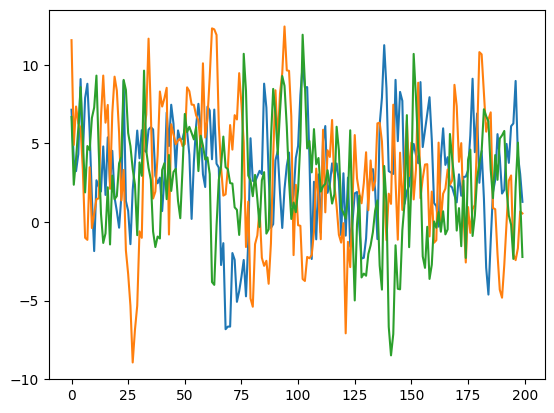

In [22]:
for l in energyTrends[:3]:
    plt.plot(l)
plt.show()

TypeError: Invalid shape (0,) for image data

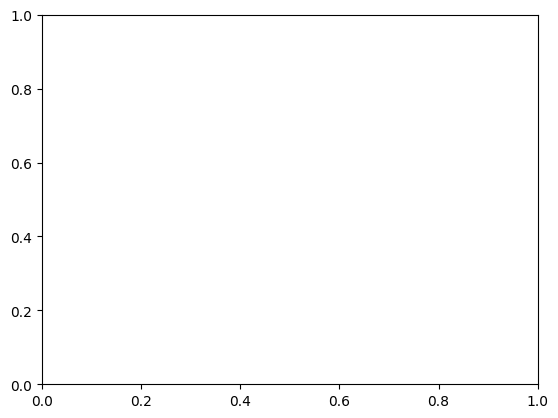

In [23]:
plt.imshow(energySampleList, aspect='auto')
plt.xlabel('sample sent index')
plt.ylabel('training iterations')
plt.colorbar().set_label('energy')
np.mean(bm.Energy_array(oneHotMatrix))

In [ ]:
energySample = bm.Energy_array(oneHotMatrix)
output = []
for i in range(60):
    random_state = bm.Random_state_unfurled()
    
    tempIndex = 0
    temperature = np.linspace(k,0,5)
    state = random_state
    for j in range(k):
        if count >=5:
            count = 0
            tempIndex+=1 
        state = bm.Forward_Gibbs_pass(state, temperature=temperature[tempIndex]))
        count+=1
    output.append(state)

energyGenerated = bm.Energy_array(output)

random_states = [bm.Random_state_unfurled() for _ in range(60)]

energyRandom = bm.Energy_array(random_states)

SyntaxError: unmatched ')' (782656660.py, line 13)

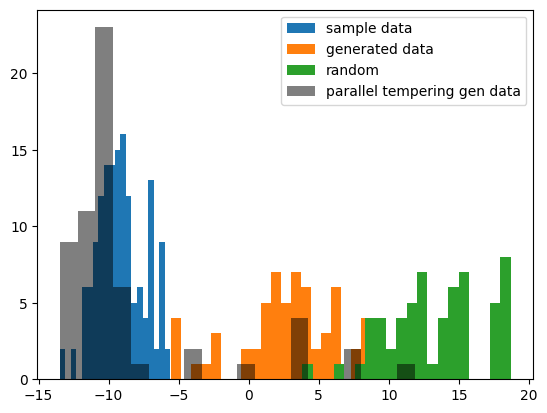

In [24]:
plt.hist(energySample, bins = 20, label='sample data')
plt.hist(energyGenerated, bins = 20, label = 'generated data')
plt.hist(energyRandom, bins = 20, label='random')
plt.hist(energyGeneratedChains, bins = 20, label='parallel tempering gen data', alpha=.5, color='black')
plt.legend()

In [ ]:
# Print Parallel Tempered Gen Data
for i in range(len(chains)):
    sentence = make_compact_state(chains[i], vocabulary)
    inData = Checker(seq=chains[i], Train_data_unfurled=oneHotMatrix)[0]
    if inData:
        continue
    print(f"InData: {inData} -- Energy: {energyGeneratedChains[i]} -- \'{' '.join(sentence.flatten())}\'")

InData: False -- Energy: -4.367343877954315 -- 'but you no commission GAP'
InData: False -- Energy: -7.379157619117391 -- 'but that would overcome do'
InData: False -- Energy: -3.359965293385948 -- 'i am in superior do'
InData: False -- Energy: -0.7962455436828842 -- 'i will care commission carriage'
InData: False -- Energy: 3.2926055951699045 -- 'her assure appeared guess always'
InData: False -- Energy: 4.072417376976895 -- 'she o'clock churchill were you'
InData: False -- Energy: 3.8978804780749634 -- 'perry's plain on a carriage'
InData: False -- Energy: 6.929463660683217 -- 'consider could quite sincerity hush'
InData: False -- Energy: 4.097636891894441 -- 'fortune mr my commission together'
InData: False -- Energy: 7.471250932585544 -- 'as did gratification mrs began'
InData: False -- Energy: 11.846027356801704 -- 'as how went date to'


In [38]:
# Print Gen Data
filter = True
for i in range(len(output)):
    sentence = make_compact_state(output[i], vocabulary)
    inData = Checker(seq=output[i], Train_data_unfurled=oneHotMatrix)[0]
    if inData:
        continue
    elif not filter: # IF not filtering just print
        print(f"InData: {inData} -- Energy: {energyGenerated[i]} -- \'{' '.join(sentence.flatten())}\'")
    elif energyGenerated[i] < 0: # IF filtering print only if < -5
        print(f"InData: {inData} -- Energy: {energyGenerated[i]} -- \'{' '.join(sentence.flatten())}\'")

InData: False -- Energy: -2.2246618068158073 -- 'i assure quite i well'
InData: False -- Energy: -3.9777228638277826 -- 'pain touch will immediate GAP'
InData: False -- Energy: -4.903453742398419 -- 'quite not emma GAP GAP'
InData: False -- Energy: -0.20232655013870726 -- 'be went feelingly come GAP'
InData: False -- Energy: -4.8652110936338016 -- 'is not to wonderful GAP'
InData: False -- Energy: -3.003182855127403 -- 'indeed you did GAP hurry'
InData: False -- Energy: -5.554223892753389 -- 'you appears quite doubt GAP'
InData: False -- Energy: -2.681348434810252 -- 'any appears quite i GAP'
InData: False -- Energy: -5.180433607361184 -- 'be observant of him temptation'
InData: False -- Energy: -0.02811458156889901 -- 'frank began unaccountable for me'
InData: False -- Energy: -2.4523433693997396 -- 'three is indispensable more GAP'


In [ ]:
# find covariance matrix for actual and generated data 
# M^T M / total num examples
output= np.array(output)
outputCoVar = (output.T @ output) / len(output)

sampleCoVar = oneHotMatrix.T @ oneHotMatrix / len(oneHotMatrix)



In [ ]:
J_sample = np.ravel(sampleCoVar)
J_output = np.ravel(outputCoVar)
S_sample = np.mean(oneHotMatrix, axis = 0)
S_output = np.mean(output, axis = 0)

In [34]:
lim = 1
plt.figure(figsize=(5,5))
plt.plot(J_sample, J_output, ".")
plt.plot(S_sample, S_output, ".")
plt.plot(np.arange(0,lim,0.1), np.arange(0,lim,0.1))

NameError: name 'J_sample' is not defined

<Figure size 500x500 with 0 Axes>

In [39]:
np.shape(oneHotMatrix)
oneHotObj.summarize()

Number of sentences (N): 149

Length of vocabulary: 290

Length of sentences count:
 [('3', 37), ('4', 55), ('5', 57)]



In [ ]:
bm2 = Multimodal_Boltzmann_Machine(numUnfurledFeat, vocabulary, learning_rate=.001)
bm2.set_weight(np.load('BMSaves/backup420/weights.npy'))
bm2.set_bias(np.load('BMSaves/backup420/biases.npy'))